In this code, we are looking to see through complaints about financial services provide by a company, we will try to see what are the major topics we have in the complaints and how are topics distrbuied in frequecnies

importing libraries

In [ ]:
# first i will install and import needed libraries
!pip install gensim

In [ ]:
# importing libraries to deal with datasets
import pandas as pd
# importing libraries for text preprocessing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
#import sklearn.feature_extraction.text
import gensim
from gensim.models.doc2vec import Doc2Vec

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


load dataset

In [ ]:
# i will load the dataset, and see how many lines and columns it have
df = pd.read_csv("complaints_processed.csv")
df = df.set_index(df.columns[0])
df

,product,narrative
Unnamed: 0,,
0,credit_card,purchase order day shipping amount receive pro...
1,credit_card,forwarded message date tue subject please inve...
2,retail_banking,forwarded message cc sent friday pdt subject f...
3,credit_reporting,payment history missing credit report speciali...
4,credit_reporting,payment history missing credit report made mis...
...,...,...
162416,debt_collection,name
162417,credit_card,name
162418,debt_collection,name


The dataset is basically a column for the complaints and a column for the type of products of each complaint

But here in this pipeline i will try to find more details about the complaints

In [ ]:
# Here i want to find missing data in the training set
# i will delete them with dropna in case ant exists
dfnull = df.isna().sum()
dfnull

product       0
narrative    10
dtype: int64

In [ ]:
# the empty rows are just in the narrative column
df = df.dropna()

In [ ]:
# i want to have several copies of the column during the changes i make to it
# that's why i keep using different variable name to each change
df2 = df['narrative']
df2

Unnamed: 0
0         purchase order day shipping amount receive pro...
1         forwarded message date tue subject please inve...
2         forwarded message cc sent friday pdt subject f...
3         payment history missing credit report speciali...
4         payment history missing credit report made mis...
                                ...                        
162416                                                 name
162417                                                 name
162418                                                 name
162419                                                 name
162420                                                 name
Name: narrative, Length: 162411, dtype: object

In [ ]:
# Here i want to find duplicate rows
# we should delete them
dfduplicate = df2.duplicated().sum()
dfduplicate

37939

In [ ]:
# we have 162411 rows,and 37939 duplicates
# now i will delete the duplicates since i will still have most of the data
df2 = df2.drop_duplicates()
print(df2.shape)

(124472,)


In [ ]:
df2

Unnamed: 0
0         purchase order day shipping amount receive pro...
1         forwarded message date tue subject please inve...
2         forwarded message cc sent friday pdt subject f...
3         payment history missing credit report speciali...
4         payment history missing credit report made mis...
                                ...                        
162411    zelle suspended account without cause banking ...
162412    zero contact made debt supposedly resolved fou...
162413    zillow home loan nmls nmls actual quote provid...
162414    zuntafi sent notice willing settle defaulted s...
162415                                                 name
Name: narrative, Length: 124472, dtype: object

In [ ]:
# here i will delete the column where we only have name
# is the only written word in the complaint
df2.drop(162415, inplace=True)
df3 = df2
df3

Unnamed: 0
0         purchase order day shipping amount receive pro...
1         forwarded message date tue subject please inve...
2         forwarded message cc sent friday pdt subject f...
3         payment history missing credit report speciali...
4         payment history missing credit report made mis...
                                ...                        
162410    zales comenity bank closed sold account report...
162411    zelle suspended account without cause banking ...
162412    zero contact made debt supposedly resolved fou...
162413    zillow home loan nmls nmls actual quote provid...
162414    zuntafi sent notice willing settle defaulted s...
Name: narrative, Length: 124471, dtype: object

Tokenization, POS, Stopwords

In [ ]:
# now i wan to use tokenization and remove irrelevant stopwords
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# i will define a function that do tokenizationa, remove stopwords and do lemmatization
def preprocessdata(texts):
    W = word_tokenize(texts.lower())
    W = [token for token in W if token not in stop_words]
    lem = WordNetLemmatizer()
    W = [lem.lemmatize(token) for token in W]
    return W

In [ ]:
# i will apply the function
df4 = df3.apply(preprocessdata)

In [ ]:
df4

Unnamed: 0
0         [purchase, order, day, shipping, amount, recei...
1         [forwarded, message, date, tue, subject, pleas...
2         [forwarded, message, cc, sent, friday, pdt, su...
3         [payment, history, missing, credit, report, sp...
4         [payment, history, missing, credit, report, ma...
                                ...                        
162410    [zales, comenity, bank, closed, sold, account,...
162411    [zelle, suspended, account, without, cause, ba...
162412    [zero, contact, made, debt, supposedly, resolv...
162413    [zillow, home, loan, nmls, nmls, actual, quote...
162414    [zuntafi, sent, notice, willing, settle, defau...
Name: narrative, Length: 124471, dtype: object

# Doc2bow and LDA

In [ ]:
# import Lda for topic modeling and ldamutlicore for a better and faster performance
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models.ldamulticore import LdaMulticore
# import corpora for bag of words and models for LDA
from gensim import corpora, models
# control warning messages
import warnings
warnings.simplefilter('ignore', category=DeprecationWarning)

In [ ]:
# creatung gensim dicitonary from the list
dictionary = corpora.Dictionary(df4)
print(dictionary.num_nnz)

7026902


In [ ]:
# using doc2bow
doctermmatrix = [dictionary.doc2bow(doc) for doc in df4]

In [ ]:
# the lda model
lda = gensim.models.ldamodel.LdaModel

In [ ]:
ldamodel = lda(doctermmatrix, num_topics=8, id2word=dictionary, passes=10, minimum_probability=0)

In [ ]:
ldamodel.print_topics(num_topics=num_topics)

[(6,
  '0.020*"call" + 0.019*"told" + 0.018*"called" + 0.017*"would" + 0.016*"time" + 0.015*"get" + 0.015*"said" + 0.014*"back" + 0.012*"phone" + 0.010*"could"'),
 (2,
  '0.076*"account" + 0.062*"credit" + 0.052*"payment" + 0.041*"balance" + 0.032*"late" + 0.023*"date" + 0.022*"report" + 0.020*"reporting" + 0.017*"paid" + 0.015*"due"'),
 (5,
  '0.080*"credit" + 0.055*"report" + 0.045*"account" + 0.037*"information" + 0.024*"inquiry" + 0.016*"reporting" + 0.014*"please" + 0.014*"inaccurate" + 0.012*"remove" + 0.012*"item"'),
 (0,
  '0.051*"debt" + 0.025*"collection" + 0.020*"credit" + 0.018*"letter" + 0.018*"company" + 0.016*"account" + 0.014*"sent" + 0.010*"provide" + 0.010*"original" + 0.009*"proof"'),
 (4,
  '0.054*"loan" + 0.035*"payment" + 0.030*"mortgage" + 0.010*"u" + 0.009*"would" + 0.009*"home" + 0.009*"received" + 0.008*"amount" + 0.008*"interest" + 0.008*"month"'),
 (3,
  '0.051*"account" + 0.040*"bank" + 0.033*"card" + 0.016*"charge" + 0.014*"money" + 0.011*"transaction" + 0

In [ ]:
from gensim import models


# Define the number of topics and top-k words
num_topics = 8
top_k_words = 10

# Get the most representative words for each topic
topic_keywords = ldamodel.show_topics(num_topics=num_topics, num_words=top_k_words)

# Define meaningful names for each topic based on the top keywords
topic_names = []

for topic in topic_keywords:
    words = topic[1].split(' + ')
    keywords = [word.split('*')[1].strip('"') for word in words]
    topic_name = ', '.join(keywords)  # we can modify this to create a meaningful name based on the keywords
    topic_names.append(topic_name)

# Print the topics with their assigned names
for i, topic_name in enumerate(topic_names):
    print(f"Topic {i}: {topic_name}")

Topic 0: debt, collection, credit, letter, company, account, sent, provide, original, proof
Topic 1: consumer, information, act, reporting, fair, section, violation, agency, fcra, may
Topic 2: account, credit, payment, balance, late, date, report, reporting, paid, due
Topic 3: account, bank, card, charge, money, transaction, chase, check, fund, fraud
Topic 4: loan, payment, mortgage, u, would, home, received, amount, interest, month
Topic 5: credit, report, account, information, inquiry, reporting, please, inaccurate, remove, item
Topic 6: call, told, called, would, time, get, said, back, phone, could
Topic 7: credit, car, year, financial, fee, time, vehicle, complaint, interest, due


In [ ]:
# assign names to the topic from the words we got from previous code
# these names will be used for the visulaization
topic_names = [
    "debt collect, report",
    "Reporting credit FCRA issues",
    "Credit payments issues",
    "Cards, transactions chekcing and security issues",
    "Loan and mortgage",
    "Credit report information issues and inaccuracies",
    "Customer service problems",
    "Car Loans and finacial fees complaints"
]

# Print the topics with their assigned names
for i, (topic, topic_name) in enumerate(zip(topic_keywords, topic_names)):
    words = topic[1].split(' + ')
    keywords = [word.split('*')[1].strip('"') for word in words]
    keywords_str = ', '.join(keywords)
    print(f"Topic {i}: {topic_name} - Keywords: {keywords_str}")

Topic 0: debt collect, report - Keywords: debt, collection, credit, letter, company, account, sent, provide, original, proof
Topic 1: Reporting credit FCRA issues - Keywords: consumer, information, act, reporting, fair, section, violation, agency, fcra, may
Topic 2: Credit payments issues - Keywords: account, credit, payment, balance, late, date, report, reporting, paid, due
Topic 3: Cards, transactions chekcing and security issues - Keywords: account, bank, card, charge, money, transaction, chase, check, fund, fraud
Topic 4: Loan and mortgage - Keywords: loan, payment, mortgage, u, would, home, received, amount, interest, month
Topic 5: Credit report information issues and inaccuracies - Keywords: credit, report, account, information, inquiry, reporting, please, inaccurate, remove, item
Topic 6: Customer service problems - Keywords: call, told, called, would, time, get, said, back, phone, could
Topic 7: Car Loans and finacial fees complaints - Keywords: credit, car, year, financial, f

In [ ]:
# Function to assign a topic label to each cell in the column
def assign_topic_label(text):
    if isinstance(text, str):
        bow_vector = ldamodel.id2word.doc2bow(text.split())
    elif isinstance(text, list):
        bow_vector = ldamodel.id2word.doc2bow(text)
    else:
        raise ValueError("Invalid input type. Expected string or list.")

    topic_probability = max(ldamodel.get_document_topics(bow_vector), key=lambda x: x[1])
    topic_label = topic_probability[0]
    return topic_names[topic_label]

# Assign topic labels to each cell in the column
df['topic_label'] = df4.apply(assign_topic_label)

In [ ]:
# combine the topic label with df4
combined_df = pd.concat([df4, df['topic_label']], axis=1)

In [ ]:
# make a csv file from the combind file
combined_df.to_csv('combined_data.csv', index=False)

In [ ]:
# assigninhg a variable name to the file
finaldf = pd.read_csv("combined_data.csv")

In [ ]:
# removing none values and seeing the file
finaldf = finaldf.dropna()
finaldf

,narrative,topic_label
0,"['purchase', 'order', 'day', 'shipping', 'amou...","Cards, transactions chekcing and security issues"
1,"['forwarded', 'message', 'date', 'tue', 'subje...",Credit payments issues
2,"['forwarded', 'message', 'cc', 'sent', 'friday...","Cards, transactions chekcing and security issues"
3,"['payment', 'history', 'missing', 'credit', 'r...",Loan and mortgage
4,"['payment', 'history', 'missing', 'credit', 'r...",Credit payments issues
...,...,...
124466,"['zales', 'comenity', 'bank', 'closed', 'sold'...",Credit payments issues
124467,"['zelle', 'suspended', 'account', 'without', '...","Cards, transactions chekcing and security issues"
124468,"['zero', 'contact', 'made', 'debt', 'supposedl...",Customer service problems
124469,"['zillow', 'home', 'loan', 'nmls', 'nmls', 'ac...",Loan and mortgage


In [ ]:
# Count the NaN values in the column
nan_count = finaldf['topic_label'].isna().sum()

print(f"Number of NaN values in 'column_name': {nan_count}")

Number of NaN values in 'column_name': 0


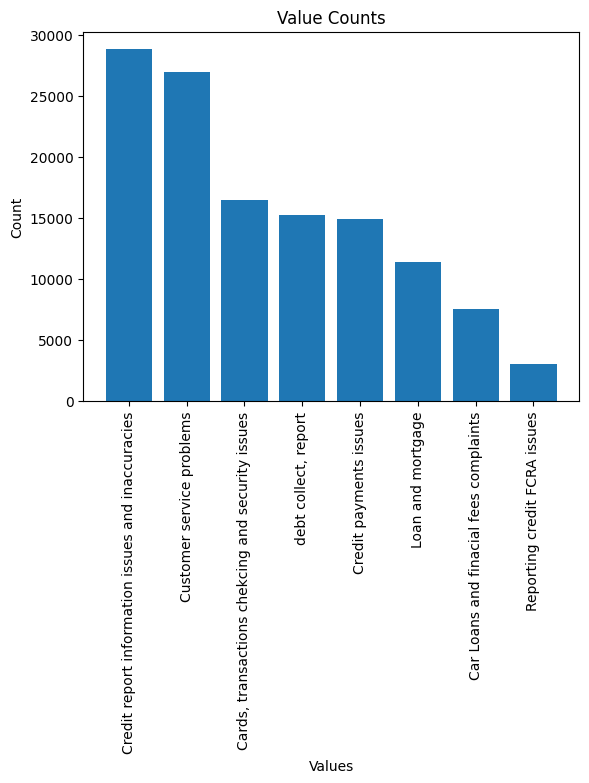

In [ ]:
# import matplotlib for visialization
import matplotlib.pyplot as plt

# Count the occurrences of each value in the column
value_counts = finaldf['topic_label'].value_counts()

# Plot the bar chart
plt.bar(value_counts.index, value_counts.values)
plt.xlabel('Values')
plt.ylabel('Count')
plt.title('Value Counts')
plt.xticks(rotation=90)
plt.show()

# Conclusion:

In this pipeline, i  was trying to get the most important topics from a dataset about complaints and see what are their frequencies to see which problems the financeial institute is facing and which should have priority to be solved first to decrease much costs as possible

I used NLP methods to extract most important and repeated words and assigned topic names for each one, and while the results might nnot be totally accurate, i still got results about some topics for the complaints and compared some to the texts we have.

Other things we can try here to get more results is to use differnet topic numbers and different key words, also use "Latent Semantic Analysis (LSA)" and "Bert" methods and compare the results to see if the topics are accurate.

# Refrencing dataset:

Tiwari.S, (2021), Consumer Complaints Dataset for NLP, Kaggle, Available at: https://www.kaggle.com/datasets/shashwatwork/consume-complaints-dataset-fo-nlp (Accessed: 27 June 2023)